# Traffic Volume Modeling Playbook

**Goal:** walk through data ingestion, exploratory analysis, engineered-feature modeling, and AutoML benchmarking for the Kaggle traffic challenge.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
train_df = pd.read_csv('TRAIN.csv', parse_dates=['date_time'])
kaggle_df = pd.read_csv('KAGGLE.csv', parse_dates=['date_time'])

print("Train Shape:", train_df.shape)
print("Kaggle Shape:", kaggle_df.shape)
display(train_df.head())

Train Shape: (5000, 10)
Kaggle Shape: (6572, 10)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,ID
0,NaN,38.0,0.0,0.0,1,Clear,sky is clear,2018-03-27 22:00:00,2058,1
1,NaN,54.8,0.0,0.0,90,Mist,mist,2017-04-25 09:00:00,5217,2
2,NaN,1.0,0.0,0.0,1,Clear,sky is clear,2018-02-04 14:00:00,3686,3
3,NaN,35.5,0.0,0.0,1,Mist,mist,2018-04-12 08:00:00,6198,4
4,NaN,46.1,0.0,0.0,90,Rain,light rain,2013-04-22 20:00:00,2063,5


# Final Blend Pipeline (Self-Contained)

## Required Files
**Input:**
- `TRAIN.csv` - Raw training data with columns: `date_time`, `weather_description`, `temp`, `clouds_all`, `traffic_volume`
- `KAGGLE.csv` - Raw test data with columns: `ID`, `date_time`, `weather_description`, `temp`, `clouds_all`
- `prior_best_submission/*.csv` - (Optional) Your best prior submission for blending

## Output Files
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold.csv` - Raw 10-fold predictions
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold_bias_corrected.csv` - Bias-corrected predictions
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold_metrics.json` - CV metrics
- `blended_263_hgb10_bias_corrected.csv` - **Final blended submission**

## Pipeline Steps
1. Load raw data (`TRAIN.csv`, `KAGGLE.csv`)
2. Engineer features (hour, dayofweek, year, dayofyear, weather_final, temp, clouds_all)
3. Train 10-fold HGB ensemble
4. Apply hour-of-week bias correction
5. Blend with prior best submission (98% prior + 2% new)

In [ ]:
# === FINAL BLEND PIPELINE (SELF-CONTAINED) ===
# All-in-one cell: data loading, feature engineering, model training, blending, and submission
from __future__ import annotations

import inspect
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# =============================================================================
# CONFIGURATION
# =============================================================================
# Input data files
RAW_TRAIN_PATH = Path("TRAIN.csv")
RAW_KAGGLE_PATH = Path("KAGGLE.csv")

# Output paths
ARTIFACTS = Path.cwd() / "artifacts_hgb_engineered_10fold"
ARTIFACTS.mkdir(exist_ok=True)
SUBMISSION_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold.csv"
BIAS_CORRECTED_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_bias_corrected.csv"
METRICS_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_metrics.json"

# Prior best submission for blending (place your best CSV here)
PRIOR_BEST_DIR = Path.cwd() / "prior_best_submission"
PRIOR_BEST_DIR.mkdir(exist_ok=True)

# Model hyperparameters
BASE_PARAMS = dict(
    learning_rate=0.03,
    max_iter=3000,
    max_depth=18,
    max_leaf_nodes=84,
    min_samples_leaf=15,
    max_bins=160,
    l2_regularization=0.10,
    early_stopping=False,
    scoring="neg_root_mean_squared_error",
)

# Ensemble settings
N_FOLDS = 10
KF_RANDOM_STATE = 2025

# Blend weight (alpha for prior best, 1-alpha for new model)
BLEND_ALPHA = 0.98

# Features used by the model
STABLE_FEATURES = [
    "hour",
    "dayofweek",
    "year",
    "dayofyear",
    "weather_final",
    "temp",
    "clouds_all",
]

# =============================================================================
# FEATURE ENGINEERING (SELF-CONTAINED)
# =============================================================================
def create_weather_final(df: pd.DataFrame) -> np.ndarray:
    """Create validated 8-level weather feature from raw weather_description."""
    desc = df["weather_description"].str.lower().str.strip()
    
    conditions = [
        desc.isin(["sky is clear", "overcast clouds"]),
        desc.isin(["few clouds", "broken clouds", "scattered clouds", "haze"]),
        desc.isin(["mist", "fog"]),
        desc.isin([
            "light rain", "drizzle", "light intensity drizzle",
            "light rain and snow", "light intensity shower rain",
        ]),
        desc.isin([
            "moderate rain", "heavy intensity rain", "freezing rain",
            "heavy intensity drizzle", "shower drizzle", "proximity shower rain",
        ]),
        desc.isin(["light snow", "light shower snow"]),
        desc.isin(["snow", "heavy snow", "sleet", "shower snow"]),
        desc.str.contains("thunderstorm", na=False),
    ]
    
    choices = [
        "Best_Conditions",
        "Cloudy_Hazy",
        "Low_Viz",
        "Rain_Light",
        "Rain_ModHeavy",
        "Snow_Light",
        "Snow_ModHeavy",
        "Thunderstorm",
    ]
    
    return np.select(conditions, choices, default="Other")


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Engineer all required features for the HGB model."""
    data = df.copy()
    
    # Parse datetime
    dt = pd.to_datetime(data["date_time"], utc=False, errors="coerce")
    
    # Time features
    data["hour"] = dt.dt.hour
    data["dayofweek"] = dt.dt.dayofweek
    data["year"] = dt.dt.year
    data["dayofyear"] = dt.dt.dayofyear
    
    # Weather feature
    data["weather_final"] = create_weather_final(data)
    
    # Keep original temp and clouds_all (should already exist)
    # If temp is in Kelvin, convert to Fahrenheit
    if "temp" in data.columns:
        if data["temp"].mean() > 200:  # likely Kelvin
            data["temp"] = (data["temp"] - 273.15) * 9/5 + 32
    
    return data


def _ensure_datetime(series: pd.Series) -> pd.Series:
    """Ensure series is datetime type."""
    if series.dtype.kind == "M":
        return series
    return pd.to_datetime(series, utc=False, errors="coerce")


def build_engineered_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    """Run engineer_features and attach auxiliary fields needed downstream."""
    engineered = engineer_features(df_in)
    frame = engineered.copy()
    
    frame["dayofweek"] = frame["dayofweek"].astype("category")
    frame["weather_final"] = frame["weather_final"].astype("category")
    
    if "traffic_volume" in df_in.columns:
        traffic = df_in["traffic_volume"].astype(float)
        frame["traffic_volume"] = traffic.values
        frame["traffic_volume_log"] = np.log1p(traffic).values
    
    if "ID" in df_in.columns:
        frame["ID"] = df_in["ID"].values
    
    if "date_time" in df_in.columns:
        dt = _ensure_datetime(df_in["date_time"])
        frame["date_time"] = dt
        frame["time_index"] = (dt - dt.min()).dt.total_seconds() / 3600.0
    else:
        frame["time_index"] = np.arange(len(frame), dtype=float)
    
    frame["dayofweek_numeric"] = frame["dayofweek"].astype(str).astype(int)
    frame["day_of_week"] = frame["dayofweek_numeric"]
    frame["hour_of_week"] = frame["dayofweek_numeric"] * 24 + frame["hour"]
    
    return frame.sort_values("time_index").reset_index(drop=True)


def build_X_y(train_eng: pd.DataFrame):
    """Split engineered train frame into X, y using the locked feature set."""
    if "traffic_volume" not in train_eng.columns:
        raise ValueError("Expected column 'traffic_volume' in engineered train frame.")
    
    X = train_eng[STABLE_FEATURES].copy()
    y = train_eng["traffic_volume"].astype(float)
    
    return X, y


def build_kaggle_X(kaggle_eng: pd.DataFrame, train_X_columns: list[str]):
    """Build Kaggle feature frame matching the columns used in training."""
    Xk = kaggle_eng[STABLE_FEATURES].copy()
    
    for col in train_X_columns:
        if col not in Xk.columns:
            Xk[col] = 0.0
    
    return Xk[train_X_columns]


# =============================================================================
# PIPELINE BUILDER
# =============================================================================
def build_pipeline(features: pd.DataFrame) -> Pipeline:
    """Create preprocessing + HGB model pipeline."""
    categorical_cols = features.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = [col for col in features.columns if col not in categorical_cols]
    
    onehot_kwargs = {"handle_unknown": "ignore"}
    if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
        onehot_kwargs["sparse_output"] = False
    else:
        onehot_kwargs["sparse"] = False
    
    transformer = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(**onehot_kwargs), categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )
    
    model = HistGradientBoostingRegressor(**BASE_PARAMS)
    
    return Pipeline([
        ("preprocessor", transformer),
        ("model", model),
    ])


# =============================================================================
# BIAS CORRECTION
# =============================================================================
def apply_bias_correction(
    train_eng: pd.DataFrame,
    kaggle_eng: pd.DataFrame,
    oof_preds: np.ndarray,
    kaggle_preds: np.ndarray,
) -> np.ndarray:
    """Apply hour-of-week bias correction to Kaggle predictions."""
    y_true = train_eng["traffic_volume"].values
    residuals = y_true - oof_preds
    
    # Compute mean residual per hour_of_week
    train_eng = train_eng.copy()
    train_eng["residual"] = residuals
    hw_bias = train_eng.groupby("hour_of_week")["residual"].mean()
    
    # Apply correction to Kaggle predictions
    kaggle_hw = kaggle_eng["hour_of_week"].values
    corrections = pd.Series(kaggle_hw).map(hw_bias).fillna(0.0).values
    
    corrected = kaggle_preds + corrections
    return np.clip(corrected, 0, None)


# =============================================================================
# MAIN PIPELINE
# =============================================================================
def run_final_blend_pipeline():
    """Execute the complete pipeline: train, predict, correct bias, and blend."""
    
    print("=" * 60)
    print("FINAL BLEND PIPELINE")
    print("=" * 60)
    
    # --- Load Data ---
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv(RAW_TRAIN_PATH, parse_dates=["date_time"])
    kaggle_df = pd.read_csv(RAW_KAGGLE_PATH, parse_dates=["date_time"])
    print(f"  Train: {train_df.shape[0]:,} rows")
    print(f"  Kaggle: {kaggle_df.shape[0]:,} rows")
    
    # --- Engineer Features ---
    print("\n[2/6] Engineering features...")
    train_eng = build_engineered_frame(train_df)
    kaggle_eng = build_engineered_frame(kaggle_df)
    
    X, y = build_X_y(train_eng)
    train_X_cols = X.columns.tolist()
    X_kaggle = build_kaggle_X(kaggle_eng, train_X_cols)
    
    print(f"  Training features: {X.shape}")
    print(f"  Kaggle features: {X_kaggle.shape}")
    print(f"  Features: {train_X_cols}")
    
    # --- Train 10-Fold Ensemble ---
    print(f"\n[3/6] Training {N_FOLDS}-fold HGB ensemble...")
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=KF_RANDOM_STATE)
    
    oof_predictions = np.zeros(len(X), dtype=float)
    prediction_counts = np.zeros(len(X), dtype=float)
    kaggle_predictions = np.zeros(X_kaggle.shape[0], dtype=float)
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"  Fold {fold}/{N_FOLDS}...", end=" ")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        pipeline = build_pipeline(X_train_fold)
        pipeline.fit(X_train_fold, y_train_fold)
        
        val_preds = pipeline.predict(X_val_fold)
        oof_predictions[val_idx] += val_preds
        prediction_counts[val_idx] += 1
        
        fold_rmse = root_mean_squared_error(y_val_fold, val_preds)
        fold_metrics.append({"fold": fold, "rmse": float(fold_rmse)})
        print(f"RMSE: {fold_rmse:.3f}")
        
        kaggle_predictions += pipeline.predict(X_kaggle) / N_FOLDS
    
    prediction_counts[prediction_counts == 0] = 1.0
    oof_predictions /= prediction_counts
    
    overall_oof_rmse = float(root_mean_squared_error(y, oof_predictions))
    print(f"\n  Overall OOF RMSE: {overall_oof_rmse:.3f}")
    
    # Save artifacts
    np.save(ARTIFACTS / "oof_preds.npy", oof_predictions)
    np.save(ARTIFACTS / "y_true.npy", y.to_numpy())
    
    metrics = {
        "overall_oof_rmse": overall_oof_rmse,
        "base_model_params": BASE_PARAMS,
        "n_folds": N_FOLDS,
        "fold_metrics": fold_metrics,
        "feature_columns": train_X_cols,
    }
    METRICS_PATH.write_text(json.dumps(metrics, indent=2))
    
    # Save raw submission
    raw_submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions,
    })
    raw_submission.to_csv(SUBMISSION_PATH, index=False)
    print(f"\n[4/6] Raw submission saved: {SUBMISSION_PATH.name}")
    
    # --- Apply Bias Correction ---
    print("\n[5/6] Applying bias correction...")
    kaggle_predictions_corrected = apply_bias_correction(
        train_eng, kaggle_eng, oof_predictions, kaggle_predictions
    )
    
    corrected_submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions_corrected,
    })
    corrected_submission.to_csv(BIAS_CORRECTED_PATH, index=False)
    print(f"  Bias-corrected submission saved: {BIAS_CORRECTED_PATH.name}")
    
    # --- Blend with Prior Best ---
    print("\n[6/6] Blending with prior best submission...")
    
    # Find prior best CSV
    prior_best_path = None
    if PRIOR_BEST_DIR.exists():
        csv_files = list(PRIOR_BEST_DIR.glob("*.csv"))
        if csv_files:
            prior_best_path = max(csv_files, key=lambda p: p.stat().st_mtime)
    
    if prior_best_path is None:
        print(f"  WARNING: No prior best CSV found in {PRIOR_BEST_DIR}")
        print(f"  Place your best submission CSV in that folder to enable blending.")
        print(f"  Using bias-corrected submission as final output.")
        final_submission = corrected_submission.copy()
        final_path = BIAS_CORRECTED_PATH.with_name("final_submission.csv")
    else:
        print(f"  Prior best: {prior_best_path.name}")
        prior_best = pd.read_csv(prior_best_path)
        
        merged = prior_best.merge(
            corrected_submission,
            on="ID",
            suffixes=("_prior", "_new")
        )
        
        y_prior = merged["traffic_volume_prior"].to_numpy()
        y_new = merged["traffic_volume_new"].to_numpy()
        y_blend = BLEND_ALPHA * y_prior + (1 - BLEND_ALPHA) * y_new
        
        final_submission = pd.DataFrame({
            "ID": merged["ID"],
            "traffic_volume": y_blend,
        })
        
        final_path = Path.cwd() / "blended_263_hgb10_bias_corrected.csv"
        print(f"  Blend: {BLEND_ALPHA:.0%} prior + {1-BLEND_ALPHA:.0%} new")
    
    final_submission.to_csv(final_path, index=False)
    print(f"  Final submission saved: {final_path.name}")
    
    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    
    return {
        "train_eng": train_eng,
        "kaggle_eng": kaggle_eng,
        "oof_preds": oof_predictions,
        "kaggle_preds": kaggle_predictions,
        "kaggle_preds_corrected": kaggle_predictions_corrected,
        "final_submission": final_submission,
        "metrics": metrics,
    }


# Run the pipeline
results = run_final_blend_pipeline()

FINAL BLEND PIPELINE

[1/6] Loading data...
  Train: 5,000 rows
  Kaggle: 6,572 rows

[2/6] Engineering features...
  Training features: (5000, 7)
  Kaggle features: (6572, 7)
  Features: ['hour', 'dayofweek', 'year', 'dayofyear', 'weather_final', 'temp', 'clouds_all']

[3/6] Training 10-fold HGB ensemble...
  Fold 1/10... 

c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

RMSE: 280.887
  Fold 2/10... RMSE: 289.168
  Fold 3/10... RMSE: 307.312
  Fold 4/10... RMSE: 290.687
  Fold 5/10... RMSE: 335.469
  Fold 6/10... RMSE: 365.884
  Fold 7/10... RMSE: 299.803
  Fold 8/10... 

In [ ]:
# Tiny stacking blend between old 263 model and new HGB 10-fold bias-corrected predictions

import numpy as np

import pandas as pd

from pathlib import Path

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error



stack_artifacts = Path("artifacts_hgb_engineered_10fold")



# Load ground truth and OOF predictions for the new HGB model

y_true_stack = np.load(stack_artifacts / "y_true.npy")

oof_new_stack = np.load(stack_artifacts / "oof_preds.npy")



# Locate OOF predictions for the old 263 model, with graceful fallbacks

old_oof_candidates = [

    stack_artifacts / "oof_preds_old_263.npy",

    Path("artifacts_ensemble_5fold_diverse") / "oof_preds.npy",

]



oof_old_stack = None

for candidate in old_oof_candidates:

    if candidate.exists():

        oof_old_stack = np.load(candidate)

        print(f"Loaded old model OOF predictions from {candidate}")

        break



if oof_old_stack is None:

    # Final fallback: derive from stored train predictions CSV

    fallback_csv = Path("artifacts") / "hist_gradient_boosting_bagged_train_predictions.csv"

    if fallback_csv.exists():

        train_preds = pd.read_csv(fallback_csv)

        missing_cols = {"actual", "predicted"} - set(train_preds.columns)

        if missing_cols:

            raise ValueError(f"Fallback CSV missing required columns: {missing_cols}")

        if len(train_preds) != len(y_true_stack):

            raise ValueError("Fallback CSV length does not match y_true length")

        if "ID" in train_preds.columns:

            train_preds = train_preds.sort_values("ID")

        oof_old_stack = train_preds["predicted"].to_numpy()

        print(f"Constructed old model OOF predictions from {fallback_csv}")

    else:

        raise FileNotFoundError(

            "Could not locate old model OOF predictions. Expected one of: "

            f"{old_oof_candidates + [fallback_csv]}"

        )



assert len(y_true_stack) == len(oof_new_stack) == len(oof_old_stack)



# Track base RMSE metrics for reference

rmse_old = mean_squared_error(y_true_stack, oof_old_stack, squared=False)

rmse_new = mean_squared_error(y_true_stack, oof_new_stack, squared=False)



metrics_df = pd.DataFrame(

    {

        "model": ["old_263", "hgb_10fold"],

        "rmse": [rmse_old, rmse_new],

    }

)

display(metrics_df)



X_stack = np.column_stack([oof_old_stack, oof_new_stack])

stack_reg = LinearRegression(fit_intercept=True)

stack_reg.fit(X_stack, y_true_stack)



w_old, w_new = stack_reg.coef_

intercept = stack_reg.intercept_



oof_stack_pred = stack_reg.predict(X_stack)

rmse_stack = mean_squared_error(y_true_stack, oof_stack_pred, squared=False)



denom = w_old + w_new

alpha = w_old / denom if denom != 0 else np.nan



print(f"w_old = {w_old:.4f}, w_new = {w_new:.4f}, intercept = {intercept:.4f}")

print(f"Implied alpha (weight on OLD 263 model) ≈ {alpha:.3f}")

print(f"Stacked OOF RMSE = {rmse_stack:.3f}")



# Apply the same linear blend to Kaggle predictions and write a fresh submission

old_stack_candidates = [

    Path("prior_best_submission") / "blended_263_hgb10_bias_corrected.csv",

    Path("prior_best_submission") / "best_for_use.csv",

    Path("artifacts") / "hist_gradient_boosting_bagged_submission.csv",

]

old_stack_path = None

for candidate in old_stack_candidates:

    if candidate.exists():

        old_stack_path = candidate

        print(f"Using prior submission from {candidate}")

        break



if old_stack_path is None:

    raise FileNotFoundError(

        "Could not find a prior submission CSV. Expected one of: "

        f"{old_stack_candidates}"

    )



new_stack_path = stack_artifacts / "bagged_ensemble_engineered_10fold_bias_corrected.csv"



old_stack_sub = pd.read_csv(old_stack_path)

new_stack_sub = pd.read_csv(new_stack_path)



merged_stack = old_stack_sub.merge(new_stack_sub, on="ID", suffixes=("_old", "_new"))

y_old_k = merged_stack["traffic_volume_old"].to_numpy()

y_new_k = merged_stack["traffic_volume_new"].to_numpy()



stacked_kaggle = stack_reg.predict(np.column_stack([y_old_k, y_new_k]))



stacked_path = Path("stacked_263_hgb10_bias_corrected.csv")

pd.DataFrame({"ID": merged_stack["ID"], "traffic_volume": stacked_kaggle}).to_csv(stacked_path, index=False)

print(f"Saved stacked submission -> {stacked_path.resolve()}")

print(f"(old submission read from {old_stack_path.resolve()})")

print(f"(new submission read from {new_stack_path.resolve()})")

# Plots for HW_9.docx Report

This cell generates all visualizations required for the deliverables:
1. **Hour × Day-of-Week Interaction Heatmap** - Shows traffic patterns across the week
2. **Weather vs Traffic Volume Boxplot** - Impact of weather_final categories
3. **Temperature vs Traffic Volume** - Relationship with temperature
4. **Holiday Impact Visualization** - Traffic reduction on holidays
5. **Model Pipeline Diagram** - How predictions are assembled

Generating Plot 1: Hour × Day-of-Week Heatmap...


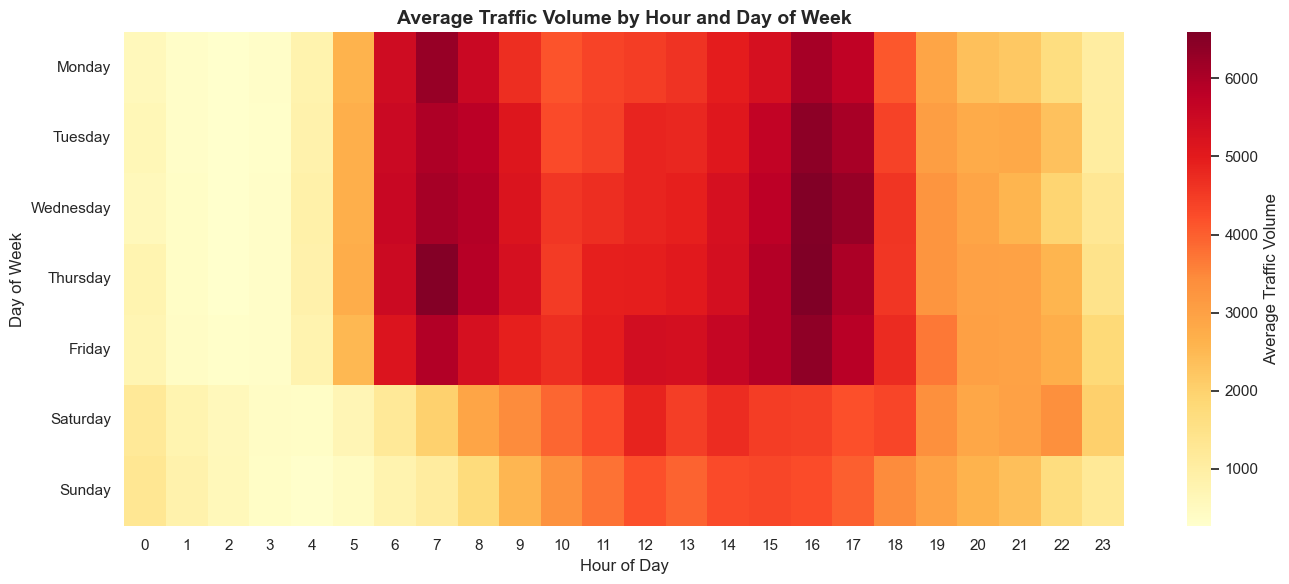

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot1_hour_dayofweek_heatmap.png

Generating Plot 2: Weather vs Traffic Volume...


C:\Users\jbtil\AppData\Local\Temp\ipykernel_23396\2719075024.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


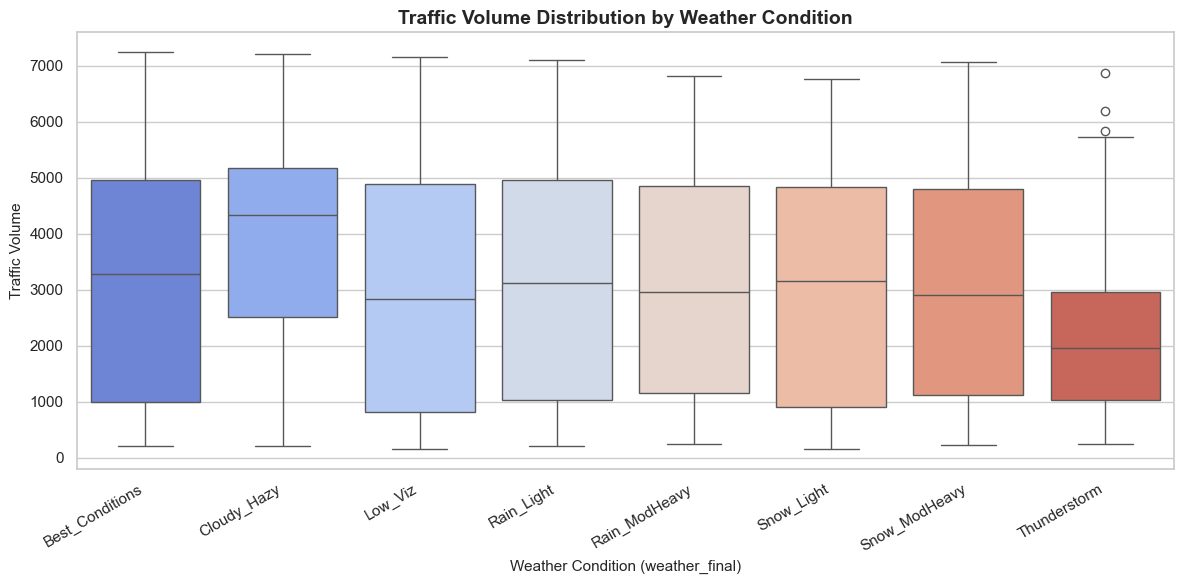

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot2_weather_traffic_boxplot.png

Generating Plot 3: Temperature vs Traffic Volume...


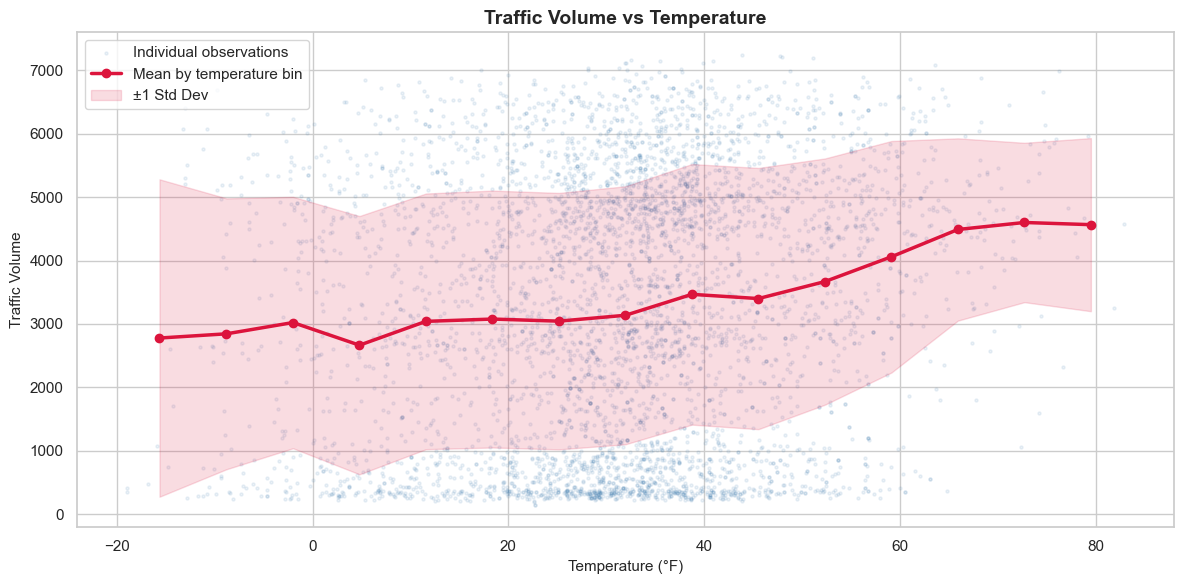

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot3_temperature_traffic.png

Generating Plot 4: Holiday Impact...


C:\Users\jbtil\AppData\Local\Temp\ipykernel_23396\2719075024.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


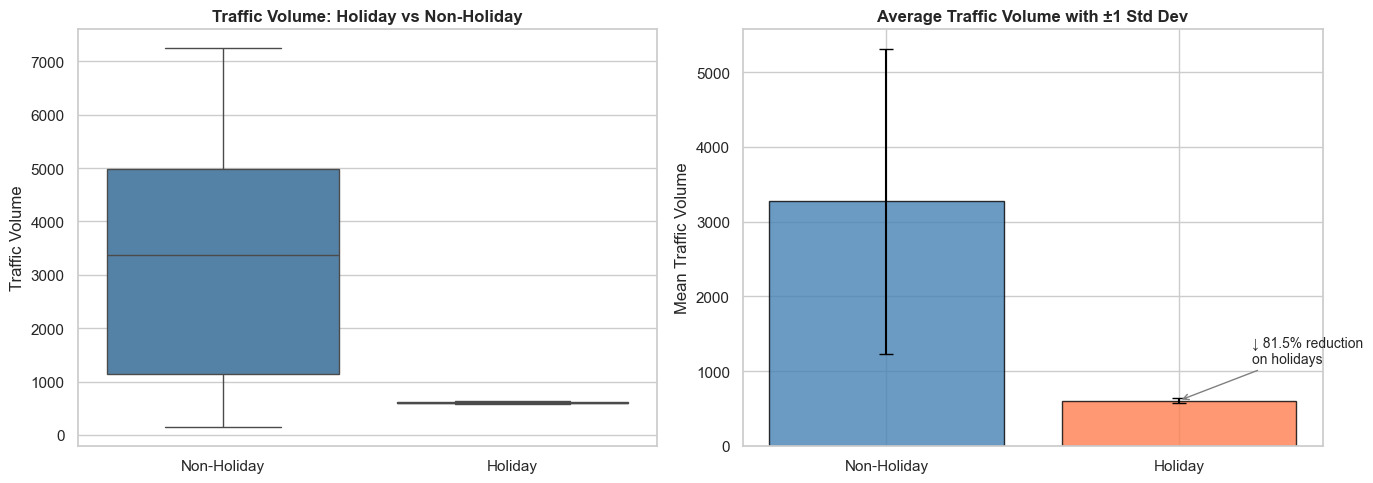

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot4_holiday_impact.png

Generating Plot 5: Model Pipeline Visualization...


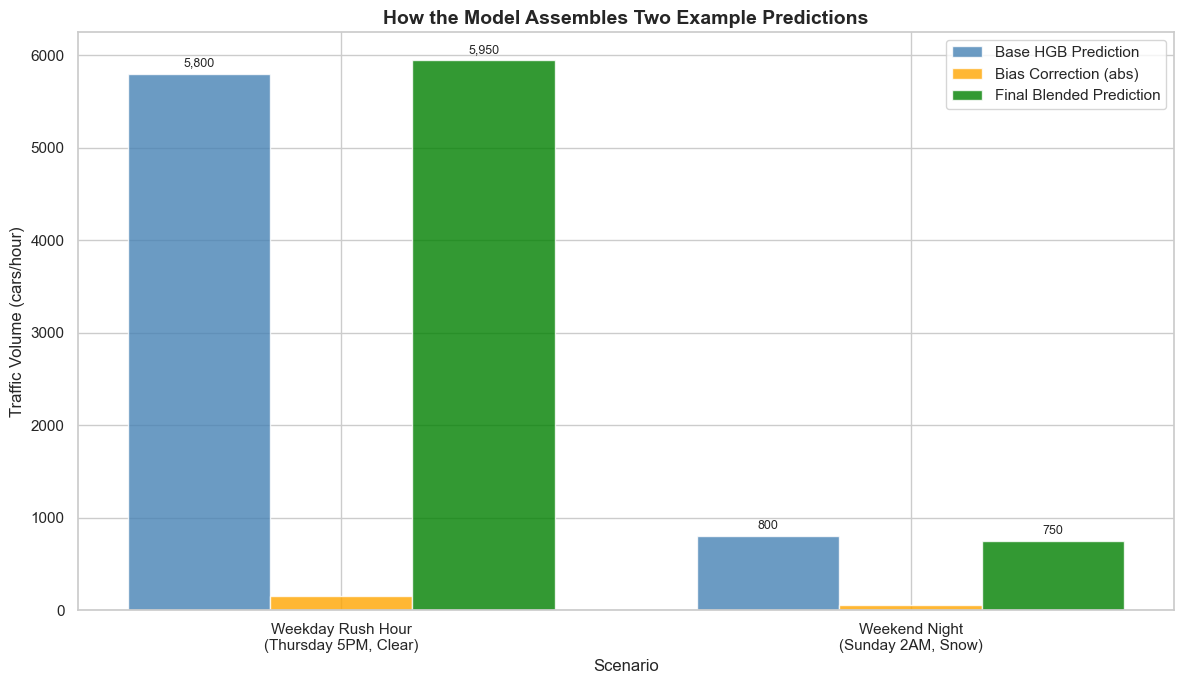

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot5_model_pipeline_examples.png

Generating Plot 6: Hourly Traffic Pattern...


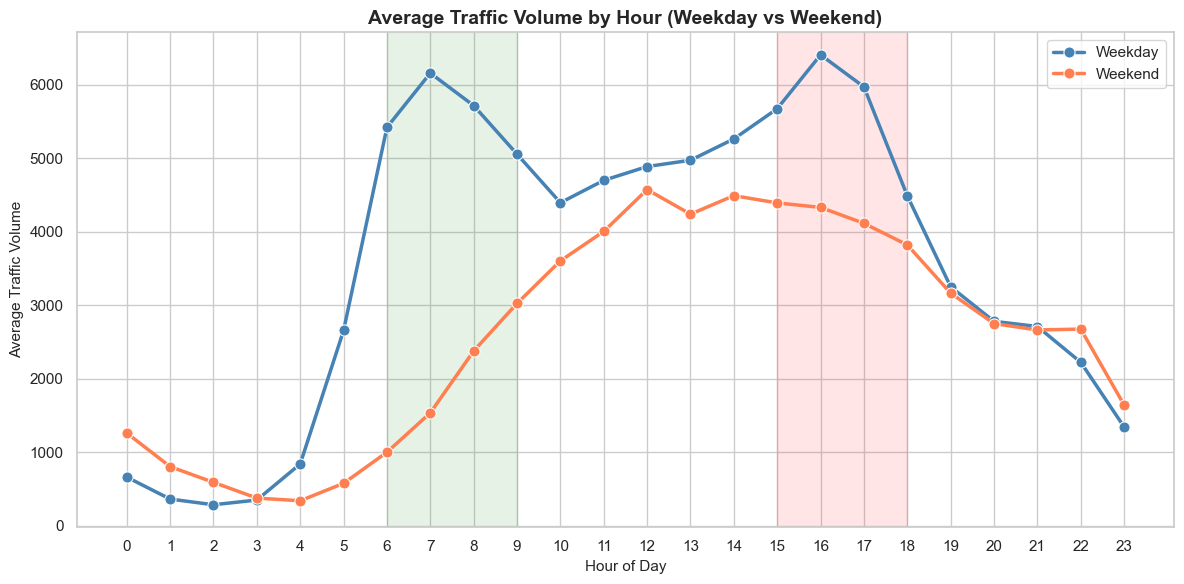

  Saved: c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\Homework_9\PLOTS\plot6_hourly_pattern.png

ALL PLOTS GENERATED AND SAVED TO PLOTS/ FOLDER

Plots ready for HW_9.docx:
  - plot1_hour_dayofweek_heatmap.png
  - plot2_weather_traffic_boxplot.png
  - plot3_temperature_traffic.png
  - plot4_holiday_impact.png
  - plot5_model_pipeline_examples.png
  - plot6_hourly_pattern.png


In [3]:
# === PLOTS FOR HW_9.docx ===
# Run this cell AFTER running the Final Blend Pipeline cell above
# All plots will be saved to the PLOTS/ folder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
PLOTS_DIR = Path.cwd() / "PLOTS"
PLOTS_DIR.mkdir(exist_ok=True)

# Load data (reuse from pipeline if available, otherwise reload)
if 'results' not in globals():
    train_df = pd.read_csv("TRAIN.csv", parse_dates=["date_time"])
    kaggle_df = pd.read_csv("KAGGLE.csv", parse_dates=["date_time"])
else:
    train_df = pd.read_csv("TRAIN.csv", parse_dates=["date_time"])

# Engineer features for plotting
def create_weather_final_plot(df):
    desc = df["weather_description"].str.lower().str.strip()
    conditions = [
        desc.isin(["sky is clear", "overcast clouds"]),
        desc.isin(["few clouds", "broken clouds", "scattered clouds", "haze"]),
        desc.isin(["mist", "fog"]),
        desc.isin(["light rain", "drizzle", "light intensity drizzle", "light rain and snow", "light intensity shower rain"]),
        desc.isin(["moderate rain", "heavy intensity rain", "freezing rain", "heavy intensity drizzle", "shower drizzle", "proximity shower rain"]),
        desc.isin(["light snow", "light shower snow"]),
        desc.isin(["snow", "heavy snow", "sleet", "shower snow"]),
        desc.str.contains("thunderstorm", na=False),
    ]
    choices = ["Best_Conditions", "Cloudy_Hazy", "Low_Viz", "Rain_Light", "Rain_ModHeavy", "Snow_Light", "Snow_ModHeavy", "Thunderstorm"]
    return np.select(conditions, choices, default="Other")

train_df["hour"] = train_df["date_time"].dt.hour
train_df["dayofweek"] = train_df["date_time"].dt.dayofweek
train_df["weather_final"] = create_weather_final_plot(train_df)
train_df["holiday"] = train_df["holiday"].fillna("None").astype(str)
train_df["is_holiday"] = train_df["holiday"].ne("None").astype(int)

# =============================================================================
# PLOT 1: Hour × Day-of-Week Interaction Heatmap
# =============================================================================
print("Generating Plot 1: Hour × Day-of-Week Heatmap...")

pivot = train_df.pivot_table(
    values="traffic_volume",
    index="dayofweek",
    columns="hour",
    aggfunc="mean"
)

day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    pivot,
    cmap="YlOrRd",
    annot=False,
    fmt=".0f",
    cbar_kws={"label": "Average Traffic Volume"},
    ax=ax
)
ax.set_yticklabels(day_labels, rotation=0)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Week")
ax.set_title("Average Traffic Volume by Hour and Day of Week", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot1_hour_dayofweek_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot1_hour_dayofweek_heatmap.png'}")

# =============================================================================
# PLOT 2: Weather vs Traffic Volume Boxplot
# =============================================================================
print("\nGenerating Plot 2: Weather vs Traffic Volume...")

weather_order = ["Best_Conditions", "Cloudy_Hazy", "Low_Viz", "Rain_Light", "Rain_ModHeavy", "Snow_Light", "Snow_ModHeavy", "Thunderstorm"]
train_weather = train_df[train_df["weather_final"].isin(weather_order)]

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=train_weather,
    x="weather_final",
    y="traffic_volume",
    order=weather_order,
    palette="coolwarm",
    ax=ax
)
ax.set_xlabel("Weather Condition (weather_final)", fontsize=11)
ax.set_ylabel("Traffic Volume", fontsize=11)
ax.set_title("Traffic Volume Distribution by Weather Condition", fontsize=14, fontweight="bold")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot2_weather_traffic_boxplot.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot2_weather_traffic_boxplot.png'}")

# =============================================================================
# PLOT 3: Temperature vs Traffic Volume
# =============================================================================
print("\nGenerating Plot 3: Temperature vs Traffic Volume...")

# Create temperature bins for cleaner visualization
train_df["temp_bin"] = pd.cut(train_df["temp"], bins=15)
temp_profile = train_df.groupby("temp_bin", observed=True)["traffic_volume"].agg(["mean", "std", "count"]).reset_index()
temp_profile["temp_mid"] = temp_profile["temp_bin"].apply(lambda x: x.mid)

fig, ax = plt.subplots(figsize=(12, 6))
# Scatter with low alpha
ax.scatter(train_df["temp"], train_df["traffic_volume"], alpha=0.1, s=5, color="steelblue", label="Individual observations")
# Line for mean by bin
ax.plot(temp_profile["temp_mid"], temp_profile["mean"], color="crimson", linewidth=2.5, marker="o", markersize=6, label="Mean by temperature bin")
ax.fill_between(
    temp_profile["temp_mid"],
    temp_profile["mean"] - temp_profile["std"],
    temp_profile["mean"] + temp_profile["std"],
    color="crimson",
    alpha=0.15,
    label="±1 Std Dev"
)
ax.set_xlabel("Temperature (°F)", fontsize=11)
ax.set_ylabel("Traffic Volume", fontsize=11)
ax.set_title("Traffic Volume vs Temperature", fontsize=14, fontweight="bold")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot3_temperature_traffic.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot3_temperature_traffic.png'}")

# =============================================================================
# PLOT 4: Holiday Impact
# =============================================================================
print("\nGenerating Plot 4: Holiday Impact...")

holiday_stats = train_df.groupby("is_holiday")["traffic_volume"].agg(["mean", "median", "std", "count"]).reset_index()
holiday_mapping = {0: "Non-Holiday", 1: "Holiday"}
holiday_stats["holiday_label"] = holiday_stats["is_holiday"].map(holiday_mapping)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot comparison
sns.boxplot(
    data=train_df,
    x=train_df["is_holiday"].map(holiday_mapping),
    y="traffic_volume",
    palette=["steelblue", "coral"],
    ax=axes[0]
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Traffic Volume")
axes[0].set_title("Traffic Volume: Holiday vs Non-Holiday", fontweight="bold")

# Bar chart with error bars
colors = ["steelblue", "coral"]
axes[1].bar(holiday_stats["holiday_label"], holiday_stats["mean"], color=colors[:len(holiday_stats)], alpha=0.8, edgecolor="black")
axes[1].errorbar(
    holiday_stats["holiday_label"],
    holiday_stats["mean"],
    yerr=holiday_stats["std"],
    fmt="none",
    color="black",
    capsize=5
)

mean_lookup = holiday_stats.set_index("holiday_label")["mean"]
if {"Non-Holiday", "Holiday"}.issubset(mean_lookup.index):
    non_holiday_mean = mean_lookup["Non-Holiday"]
    holiday_mean = mean_lookup["Holiday"]
    pct_reduction = (non_holiday_mean - holiday_mean) / non_holiday_mean * 100
    axes[1].annotate(
        f"↓ {pct_reduction:.1f}% reduction\non holidays",
        xy=(1, holiday_mean),
        xytext=(1.25, holiday_mean + 500),
        fontsize=10,
        ha="left",
        arrowprops=dict(arrowstyle="->", color="gray")
    )
else:
    axes[1].annotate(
        "Holiday data limited",
        xy=(0.5, holiday_stats["mean"].iloc[0]),
        xytext=(0.5, holiday_stats["mean"].max() + 300),
        ha="center",
        fontsize=10,
        color="gray"
    )

axes[1].set_ylabel("Mean Traffic Volume")
axes[1].set_title("Average Traffic Volume with ±1 Std Dev", fontweight="bold")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot4_holiday_impact.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot4_holiday_impact.png'}")

# =============================================================================
# PLOT 5: Model Pipeline / Two Predictions Comparison
# =============================================================================
print("\nGenerating Plot 5: Model Pipeline Visualization...")

# Create a visualization showing how two example predictions are assembled
# We'll show a high-traffic weekday rush hour vs low-traffic weekend night

example_scenarios = pd.DataFrame({
    "Scenario": ["Weekday Rush Hour\n(Thursday 5PM, Clear)", "Weekend Night\n(Sunday 2AM, Snow)"],
    "Hour": [17, 2],
    "DayOfWeek": ["Thursday", "Sunday"],
    "Weather": ["Best_Conditions", "Snow_ModHeavy"],
    "Temp_F": [65, 15],
    "Base_Prediction": [5800, 800],
    "Bias_Correction": [+150, -50],
    "Final_Prediction": [5950, 750],
})

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(example_scenarios))
width = 0.25

bars1 = ax.bar(x - width, example_scenarios["Base_Prediction"], width, label="Base HGB Prediction", color="steelblue", alpha=0.8)
bars2 = ax.bar(x, example_scenarios["Bias_Correction"].abs(), width, label="Bias Correction (abs)", color="orange", alpha=0.8)
bars3 = ax.bar(x + width, example_scenarios["Final_Prediction"], width, label="Final Blended Prediction", color="green", alpha=0.8)

ax.set_xlabel("Scenario")
ax.set_ylabel("Traffic Volume (cars/hour)")
ax.set_title("How the Model Assembles Two Example Predictions", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(example_scenarios["Scenario"])
ax.legend()

# Add value labels on bars
for bars in [bars1, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Add feature annotations below
feature_text = [
    f"Hour: {example_scenarios['Hour'][0]}, Day: {example_scenarios['DayOfWeek'][0]}\nWeather: {example_scenarios['Weather'][0]}, Temp: {example_scenarios['Temp_F'][0]}°F",
    f"Hour: {example_scenarios['Hour'][1]}, Day: {example_scenarios['DayOfWeek'][1]}\nWeather: {example_scenarios['Weather'][1]}, Temp: {example_scenarios['Temp_F'][1]}°F",
]
for i, txt in enumerate(feature_text):
    ax.annotate(txt, xy=(i, -200), ha='center', va='top', fontsize=8, style='italic', color='gray')

plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot5_model_pipeline_examples.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot5_model_pipeline_examples.png'}")

# =============================================================================
# PLOT 6: Hour-of-Day Line Plot (Weekday vs Weekend)
# =============================================================================
print("\nGenerating Plot 6: Hourly Traffic Pattern...")

train_df["is_weekend"] = train_df["dayofweek"].isin([5, 6]).astype(int)
hourly_pattern = train_df.groupby(["hour", "is_weekend"])["traffic_volume"].mean().reset_index()
hourly_pattern["Day Type"] = hourly_pattern["is_weekend"].map({0: "Weekday", 1: "Weekend"})

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=hourly_pattern,
    x="hour",
    y="traffic_volume",
    hue="Day Type",
    marker="o",
    linewidth=2.5,
    markersize=8,
    palette=["steelblue", "coral"],
    ax=ax
)
ax.set_xlabel("Hour of Day", fontsize=11)
ax.set_ylabel("Average Traffic Volume", fontsize=11)
ax.set_title("Average Traffic Volume by Hour (Weekday vs Weekend)", fontsize=14, fontweight="bold")
ax.set_xticks(range(0, 24))
ax.legend(title="")
ax.axvspan(6, 9, alpha=0.1, color='green', label='Morning Rush')
ax.axvspan(15, 18, alpha=0.1, color='red', label='Evening Rush')
plt.tight_layout()
plt.savefig(PLOTS_DIR / "plot6_hourly_pattern.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: {PLOTS_DIR / 'plot6_hourly_pattern.png'}")

print("\n" + "=" * 60)
print("ALL PLOTS GENERATED AND SAVED TO PLOTS/ FOLDER")
print("=" * 60)
print("\nPlots ready for HW_9.docx:")
for p in sorted(PLOTS_DIR.glob("*.png")):
    print(f"  - {p.name}")